In [1]:
import torch
from torch.nn.functional import relu
from lib.mnist_aug.mnist_augmenter import DataManager, MNISTAug

In [2]:
aug = MNISTAug()
dm = DataManager()
dm.load_test()

In [3]:
x_train, y_train = aug.get_augmented(dm.x_test, dm.y_test, 10000)
x_test, y_test = aug.get_augmented(dm.x_test, dm.y_test, 2)

In [4]:
x_train = torch.tensor(x_train.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')
x_test = torch.tensor(x_test.reshape(-1, 1, 112, 112)).type('torch.FloatTensor')

/Users/akhildevarashetti/Code/ml_gallery/ml_py/lib/mnist_aug/mnist_augmenter.py:154: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


[{'class': 1,
  'class_one_hot': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]),
  'x1': 21,
  'y1': 62,
  'x2': 56,
  'y2': 97,
  'cx': 38.5,
  'cy': 79.5,
  'height': 35,
  'width': 35}]

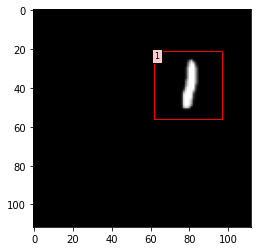

In [5]:
DataManager.plot_num(x_train[1].reshape((112, 112)), y_train[1])
y_train[1]

In [6]:
anchor_cx = 56
anchor_cy = 56
anchor_w = 28

In [7]:
def units_to_diff(y):
    y_d = []
    for i in range(len(y)):
        cx_d = (y[i][0]['cx'] - anchor_cx) / 112
        cy_d = (y[i][0]['cy'] - anchor_cy) / 112
        w_d = (y[i][0]['width'] - anchor_w) / 112
        y_d.append((cx_d, cy_d, w_d))
    return torch.tensor(y_d)

def diff_to_units(y):
    y_units = []
    for i in range(len(y)):
        cx_d = y[i][0] * 112 + anchor_cx
        cy_d = y[i][1] * 112 + anchor_cy
        wd = y[i][2] * 112 + anchor_w
        y_units.append((cx_d, cy_d, wd))
    return torch.tensor(y_units)

In [8]:
print(y_test)
y_d_test = units_to_diff(y_test)
print(y_d_test)
y_d_unwrapped = diff_to_units(y_d_test)
print(y_d_unwrapped)

[[{'class': 1, 'class_one_hot': array([0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]), 'x1': 72, 'y1': 67, 'x2': 90, 'y2': 85, 'cx': 81.0, 'cy': 76.0, 'height': 18, 'width': 18}], [{'class': 8, 'class_one_hot': array([0., 0., 0., 0., 0., 0., 0., 0., 1., 0.]), 'x1': 86, 'y1': 90, 'x2': 110, 'y2': 112, 'cx': 98.0, 'cy': 101.0, 'height': 22, 'width': 24}]]
tensor([[ 0.2232,  0.1786, -0.0893],
        [ 0.3750,  0.4018, -0.0357]])
tensor([[ 81.,  76.,  18.],
        [ 98., 101.,  24.]])


In [9]:
y_d = units_to_diff(y_train)
y_d_test = units_to_diff(y_test)

In [10]:
class DetectorV1 (torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = torch.nn.Conv2d(1, 32, 3, padding=1)  # 112x112
        self.conv2 = torch.nn.Conv2d(32, 64, 3, stride=2, padding=1)  # 56x56
        self.conv3 = torch.nn.Conv2d(64, 128, 3, stride=2, padding=1)  # 28x28
        self.conv4 = torch.nn.Conv2d(128, 256, 3, stride=2, padding=1)  # 14x14
        self.conv5 = torch.nn.Conv2d(256, 512, 3, stride=2, padding=1)  # 7x7
        self.linear1 = torch.nn.Linear(25088, 4096)
        self.linear2 = torch.nn.Linear(4096, 512)
        self.linear3 = torch.nn.Linear(512, 3)

    def forward(self, x):
        x = relu(self.conv1(x))  # 112
        x = relu(self.conv2(x))  # 56
        x = relu(self.conv3(x))  # 28
        x = relu(self.conv4(x))  # 14
        x = relu(self.conv5(x))  # 7
        x = torch.flatten(x, 1)
        x = relu(self.linear1(x))
        x = relu(self.linear2(x))
        x = torch.nn.functional.tanh(self.linear3(x))
        return x


model = DetectorV1()
optimizer = torch.optim.Adam(model.parameters())

In [15]:
epochs = 2
batch_size = 100

for epoch in range(epochs):
    
    for i in range(0, len(x_train), batch_size):
        start_index = i
        end_index = i+batch_size
        
        x_batch = x_train[start_index:end_index]
        y_batch = y_d[start_index:end_index]
        
        optimizer.zero_grad()

        y_hat = model(x_batch)

        loss = sum(sum((y_batch - y_hat)**2))
        
        loss.backward()
        optimizer.step()
        
        print(f'{epoch=}, batch={i}, loss={float(loss)}')

epoch=0, batch=0, loss=0.061099883168935776
epoch=0, batch=10, loss=0.1441323161125183
epoch=0, batch=20, loss=0.04131025820970535
epoch=0, batch=30, loss=0.12986722588539124
epoch=0, batch=40, loss=0.05254726484417915
epoch=0, batch=50, loss=0.04877208545804024
epoch=0, batch=60, loss=0.0383504293859005
epoch=0, batch=70, loss=0.09216593205928802
epoch=0, batch=80, loss=0.09075552225112915
epoch=0, batch=90, loss=0.04653157293796539
epoch=0, batch=100, loss=0.06577616930007935
epoch=0, batch=110, loss=0.05349719524383545
epoch=0, batch=120, loss=0.06906098127365112
epoch=0, batch=130, loss=0.06013179570436478
epoch=0, batch=140, loss=0.024146592244505882
epoch=0, batch=150, loss=0.027379104867577553
epoch=0, batch=160, loss=0.030461754649877548
epoch=0, batch=170, loss=0.03546753525733948
epoch=0, batch=180, loss=0.19861584901809692
epoch=0, batch=190, loss=0.056669704616069794
epoch=0, batch=200, loss=0.04703786224126816
epoch=0, batch=210, loss=0.07568567991256714
epoch=0, batch=220

epoch=1, batch=820, loss=0.03327369689941406
epoch=1, batch=830, loss=0.022221066057682037
epoch=1, batch=840, loss=0.020134780555963516
epoch=1, batch=850, loss=0.029627757146954536
epoch=1, batch=860, loss=0.02845510095357895
epoch=1, batch=870, loss=0.020908791571855545
epoch=1, batch=880, loss=0.025399185717105865
epoch=1, batch=890, loss=0.03415156155824661
epoch=1, batch=900, loss=0.02706643007695675
epoch=1, batch=910, loss=0.015342127531766891
epoch=1, batch=920, loss=0.019997674971818924
epoch=1, batch=930, loss=0.019294749945402145
epoch=1, batch=940, loss=0.013222961686551571
epoch=1, batch=950, loss=0.021440332755446434
epoch=1, batch=960, loss=0.015945736318826675
epoch=1, batch=970, loss=0.007941056042909622
epoch=1, batch=980, loss=0.011287192814052105
epoch=1, batch=990, loss=0.020220141857862473


y_pred=tensor([[ 0.2621,  0.1862, -0.0496],
        [ 0.3322,  0.3651, -0.0427]])
y_d_test=tensor([[ 0.2232,  0.1786, -0.0893],
        [ 0.3750,  0.4018, -0.0357]])
[{'x1': 74.13916778564453, 'y1': 65.63678741455078, 'x2': 96.58092498779297, 'y2': 88.07854461669922}]
[{'x1': 81.60196685791016, 'y1': 85.287109375, 'x2': 104.82074737548828, 'y2': 108.50588989257812}]


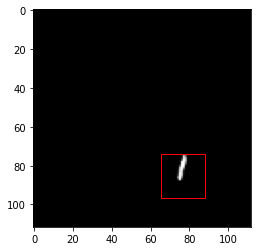

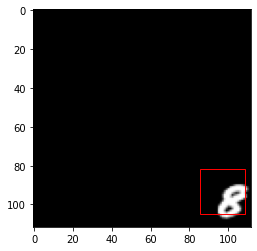

In [16]:
with torch.no_grad():
    y_pred = model(x_test)
    
    print(f'{y_pred=}\n{y_d_test=}')
    
    y_pred = diff_to_units(y_pred)
    for i in range(len(y_pred)):

        cx_pred, cy_pred, w_pred = y_pred[i]
        pred_boxes = [{
            'x1': float(cx_pred - w_pred / 2),
            'y1': float(cy_pred - w_pred / 2),
            'x2': float(cx_pred + w_pred / 2),
            'y2': float(cy_pred + w_pred / 2)
        }]

        # pred_boxes.extend(list(y_test[i]))
        print(f'{pred_boxes}')

        DataManager.plot_num(x_test[i].reshape((112, 112)), pred_boxes)
